In [6]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd
import utils


C:\Users\Diego\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
def load_data():
    dataset = pd.read_excel('data.xlsx')
    print("\n")
    print('Loading Dataset shape: {}'.format(dataset.shape))
    return dataset

In [8]:
def train_test_lazy_classifier(X, y, vectorizer):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                            y, stratify=y, random_state=0)
    
    X_train_vectors = vectorizer.fit_transform(X_train)
    X_test_vectors = vectorizer.transform(X_test)

    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train_vectors.A, X_test_vectors.A, y_train, y_test)
    print("\n")
    #get best F1 Score model
    models = models.sort_values(by=['ROC AUC'] , ascending=False)
    print(models)
    print("Best Model: {}".format(models.index[0]))
    best_model = clf.models[models.index[0]]
    return vectorizer, best_model


In [10]:
dataset = load_data()
dataset = dataset[dataset.is_subjective_liwc == 1]
dataset = utils.preprocess(dataset)



Loading Dataset shape: (1778, 8)


In [11]:
dataset.shape

(1107, 8)

<AxesSubplot:>

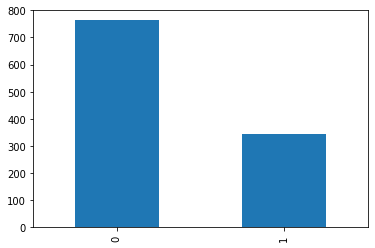

In [25]:
dataset.is_subjective_label.value_counts().plot(kind='bar')

In [12]:
X, y = dataset['preprocessed_text'], dataset['is_subjective_label']
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,1))
vectorizer, best_model = train_test_lazy_classifier(X, y, vectorizer)

100%|██████████| 29/29 [00:16<00:00,  1.81it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LogisticRegression                 0.70               0.66     0.66      0.70   
NearestCentroid                    0.68               0.64     0.64      0.69   
BernoulliNB                        0.74               0.64     0.64      0.71   
Perceptron                         0.68               0.64     0.64      0.68   
NuSVC                              0.73               0.63     0.63      0.71   
PassiveAggressiveClassifier        0.67               0.63     0.63      0.67   
LinearSVC                          0.65               0.63     0.63      0.66   
GaussianNB                         0.60               0.62     0.62      0.62   
ExtraTreesClassifier               0.73               0.62     0.62      0.70   
AdaBoostClassifier                 0.71               0.62  

In [26]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf',NearestCentroid())
])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [28]:
params = {
 'tfidf__max_features':[200, 500, 1000, 2000],
 'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)],
}

In [29]:
grid_search = GridSearchCV(pipe, cv=5, param_grid=params, n_jobs=-1, scoring='f1')

In [30]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', NearestCentroid())]),
             n_jobs=-1,
             param_grid={'tfidf__max_features': [200, 500, 1000, 2000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                                (2, 3), (3, 3)]},
             scoring='f1')

In [31]:
grid_search.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=200, ngram_range=(1, 2))),
                ('clf', NearestCentroid())])

In [32]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.505
Best parameters set:
	tfidf__max_features: 200
	tfidf__ngram_range: (1, 2)


In [33]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       191
           1       0.47      0.55      0.50        86

    accuracy                           0.66       277
   macro avg       0.62      0.63      0.62       277
weighted avg       0.68      0.66      0.67       277

